In [4]:
# Import library yang kalian butuhkan
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import math
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

## Data Loading

In [5]:
def insertPic(folder):
    data = []
    filenames = []
    datalabel = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        for filename in tqdm(os.listdir(folder+label)):
            img = cv.imread(os.path.join(folder+label, filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, (150, 150))
                filenames.append(filename)
                data.append(img)
    return data, filenames, datalabel, data_distribution


In [6]:
data, filenames, label, distribusi = insertPic("Finger Simulation Dataset 2024/")
print ("Data: ", len(data))
print ("Label: ", len(label))
print ("Filenames: ", len(filenames))
print ("Data Distribution: ", distribusi)

finger_1


100%|██████████| 442/442 [00:56<00:00,  7.79it/s]


finger_2


100%|██████████| 437/437 [00:55<00:00,  7.89it/s]


finger_3


100%|██████████| 438/438 [00:56<00:00,  7.81it/s]


finger_4


100%|██████████| 442/442 [00:55<00:00,  7.93it/s]


finger_5


100%|██████████| 440/440 [00:55<00:00,  7.92it/s]

Data:  2100
Label:  5
Filenames:  2100
Data Distribution:  {'finger_1': 442, 'finger_2': 437, 'finger_3': 438, 'finger_4': 442, 'finger_5': 440}


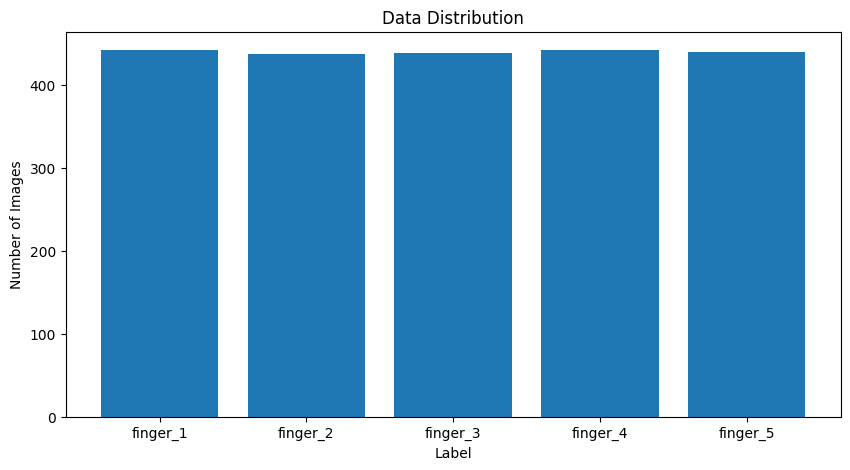

In [7]:
def distribusiPic(data_distribution):
    plt.figure(figsize = (10, 5))
    plt.bar(data_distribution.keys(), data_distribution.values())
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution')
    plt.show()
distribusiPic(distribusi)

## Data Preparation

### Data Augmentation

In [8]:
# Fungsi translasi
def translasi(image, x_shift, y_shift):
    if len(image.shape) == 3:  # Check if it's a single image
        rows, cols, _ = image.shape
        M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
        trans_img = np.zeros_like(image)
        for i in range(rows):
            for j in range(cols):
                if 0 <= i + x_shift < rows and 0 <= j + y_shift < cols:
                    trans_img[i + x_shift, j + y_shift] = image[i, j]
        return trans_img
    elif len(image[0].shape) == 3:  # Check if it's a list of images
        translated_images = []
        for img in image:
            rows, cols, _ = img.shape
            M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
            trans_img = np.zeros_like(img)
            for i in range(rows):
                for j in range(cols):
                    if 0 <= i + x_shift < rows and 0 <= j + y_shift < cols:
                        trans_img[i + x_shift, j + y_shift] = img[i, j]
            translated_images.append(trans_img)
        return translated_images
    else:
        raise ValueError("Invalid input: image should be either a single image or a list of images.")

# Fungsi flipping
def flipping(image, axis):
    if axis == 0:  # Vertical flipping
        return image[::-1, :]
    elif axis == 1:  # Horizontal flipping
        return image[:, ::-1]

# Fungsi augmentasi
def augmentasi(data, filenames, banyakData):
    augmented_data = []
    augmented_filenames = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_filenames.append(filenames[i])
        for j in range(banyakData):
            if j % 4 == 0:
                augmented_data.append(translasi(data[i], 10, 10))
                augmented_filenames.append(filenames[i])
            elif j % 4 == 1:
                augmented_data.append(translasi(data[i], -10, -10))
                augmented_filenames.append(filenames[i])
            elif j % 4 == 2:
                augmented_data.append(flipping(data[i], 0))  # Vertical flipping
                augmented_filenames.append(filenames[i])
            elif j % 4 == 3:
                augmented_data.append(flipping(data[i], 1))  # Horizontal flipping
                augmented_filenames.append(filenames[i])
    return augmented_data, augmented_filenames

In [9]:
augmented_data, augmented_filenames = augmentasi(data, filenames, 5)

100%|██████████| 2100/2100 [01:54<00:00, 18.42it/s]


### Preprocessing

#### Preprocessing 1

In [10]:
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return normalized_image

def equalize_hist(image):
    if len(image.shape) == 3:  # Convert to grayscale if it's a color image
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    hist = [0] * 256
    rows, cols = image.shape
    equalized_image = np.zeros((rows, cols), dtype=np.uint8)
    
    # Hitung histogram
    for i in range(rows):
        for j in range(cols):
            pixel_value = int(image[i, j])  # Cast pixel value to integer
            hist[pixel_value] += 1
    
    # Hitung kumulatif histogram
    cum_hist = [sum(hist[:i+1]) for i in range(256)]
    
    # Normalisasi kumulatif histogram
    cum_hist_normalized = [round((val - min(cum_hist)) / (rows * cols - min(cum_hist)) * 255) for val in cum_hist]
    
    # Aplikasikan transformasi histogram
    for i in range(rows):
        for j in range(cols):
            equalized_image[i, j] = cum_hist_normalized[int(image[i, j])]  # Cast pixel value to integer
    
    return equalized_image



def preprocess_images(images):
    preprocessed_images = []
    
    for image in tqdm(images, desc="Preprocessing"):
        normalized_image = normalize(image)
        equalized_image = equalize_hist(normalized_image)
        preprocessed_images.append(equalized_image)
    
    return preprocessed_images

# Gunakan fungsi preprocessing untuk memproses data Anda
preprocessed_images = preprocess_images(data)

Preprocessing: 100%|██████████| 2100/2100 [00:36<00:00, 58.30it/s]


### Feature Extraction

In [11]:
def calculate_glcm(image, distances=[1], angles=[0, 45, 90, 135], levels=256):
    glcm_matrices = []
    
    # Normalize the image to integer values between 0 and levels-1
    max_val = np.max(image)
    min_val = np.min(image)
    image_normalized = ((image - min_val) / (max_val - min_val) * (levels - 1)).astype(np.uint8)
    
    for angle in angles:
        glcm_matrix = np.zeros((levels, levels))
        for distance in distances:
            # Define offset for the given distance and angle
            offset_x = int(round(distance * np.cos(np.radians(angle))))
            offset_y = int(round(distance * np.sin(np.radians(angle))))
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    # Check if the pixel and its neighbor are within image bounds
                    if 0 <= i + offset_y < image.shape[0] and 0 <= j + offset_x < image.shape[1]:
                        pixel_value = image_normalized[i, j]
                        neighbor_value = image_normalized[i + offset_y, j + offset_x]
                        glcm_matrix[pixel_value, neighbor_value] += 1
        glcm_matrices.append(glcm_matrix)
    return glcm_matrices

def calculate_glcm_features(glcm_matrices):
    features = []
    for glcm_matrix in glcm_matrices:
        # Normalize GLCM matrix
        glcm_matrix /= np.sum(glcm_matrix)
        
        # Calculate features
        contrast = np.sum(glcm_matrix * np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))
        dissimilarity = np.sum(glcm_matrix * np.abs(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))

        homogeneity = np.sum(glcm_matrix / (1 + np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1]))))
        energy = np.sum(np.square(glcm_matrix))
        correlation = np.sum((np.arange(glcm_matrix.shape[0]) - np.mean(glcm_matrix)) * 
                             (np.arange(glcm_matrix.shape[1]) - np.mean(glcm_matrix)) * glcm_matrix / 
                             (np.std(glcm_matrix) ** 2))
        entropy = -np.sum(glcm_matrix * np.log(glcm_matrix + 1e-10))
        asm = np.sum(np.square(glcm_matrix))
        
        features.append({
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation,
            'entropy': entropy,
            'ASM': asm
        })
    return features


# Example usage:
# Assume you have a list of edge images called edge_images_prewitt_rotated
edge_images_prewitt_rotated = [
    # Replace with your actual edge images
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

# Calculate GLCM matrices
glcm_matrices = []
for edge_image in edge_images_prewitt_rotated:
    glcm_matrices.extend(calculate_glcm(edge_image))

# Calculate GLCM features
glcm_features = calculate_glcm_features(glcm_matrices)

# Prepare data for DataFrame
data = []
columns = ['Image', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'ASM']
for angle in [0, 45, 90, 135]:
    columns.extend([f'contrast_{angle}', f'dissimilarity_{angle}', f'homogeneity_{angle}', 
                    f'energy_{angle}', f'correlation_{angle}', f'asm_{angle}', f'entropy_{angle}'])

for i, features in enumerate(glcm_features):
    row = [i + 1, features['contrast'], features['dissimilarity'], features['homogeneity'], 
           features['energy'], features['correlation'], features['entropy'], features['ASM']]
    for angle in [0, 45, 90, 135]:
        row.extend([features['contrast'], features['dissimilarity'], features['homogeneity'], 
                    features['energy'], features['correlation'], features['entropy'], features['ASM']])
    data.append(row)

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Display results
print(df)
df.head()

   Image  Contrast  Dissimilarity  Homogeneity    Energy   Correlation  \
0      1       0.0            0.0          1.0  0.000116  1.404108e+13   
1      2       0.0            0.0          1.0  0.000118  1.373173e+13   
2      3       0.0            0.0          1.0  0.000116  1.400870e+13   
3      4       0.0            0.0          1.0  0.000117  1.384612e+13   
4      5       0.0            0.0          1.0  0.000117  1.377197e+13   
5      6       0.0            0.0          1.0  0.000116  1.384503e+13   
6      7       0.0            0.0          1.0  0.000117  1.373306e+13   
7      8       0.0            0.0          1.0  0.000119  1.352407e+13   

    Entropy       ASM  contrast_0  dissimilarity_0  ...  correlation_90  \
0  9.100791  0.000116         0.0              0.0  ...    1.404108e+13   
1  9.084534  0.000118         0.0              0.0  ...    1.373173e+13   
2  9.101066  0.000116         0.0              0.0  ...    1.400870e+13   
3  9.090459  0.000117         0.0

,Image,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,Entropy,ASM,contrast_0,dissimilarity_0,...,correlation_90,asm_90,entropy_90,contrast_135,dissimilarity_135,homogeneity_135,energy_135,correlation_135,asm_135,entropy_135
0,1,0.0,0.0,1.0,0.000116,1.404108e+13,9.100791,0.000116,0.0,0.0,...,1.404108e+13,9.100791,0.000116,0.0,0.0,1.0,0.000116,1.404108e+13,9.100791,0.000116
1,2,0.0,0.0,1.0,0.000118,1.373173e+13,9.084534,0.000118,0.0,0.0,...,1.373173e+13,9.084534,0.000118,0.0,0.0,1.0,0.000118,1.373173e+13,9.084534,0.000118
2,3,0.0,0.0,1.0,0.000116,1.400870e+13,9.101066,0.000116,0.0,0.0,...,1.400870e+13,9.101066,0.000116,0.0,0.0,1.0,0.000116,1.400870e+13,9.101066,0.000116
3,4,0.0,0.0,1.0,0.000117,1.384612e+13,9.090459,0.000117,0.0,0.0,...,1.384612e+13,9.090459,0.000117,0.0,0.0,1.0,0.000117,1.384612e+13,9.090459,0.000117
4,5,0.0,0.0,1.0,0.000117,1.377197e+13,9.094907,0.000117,0.0,0.0,...,1.377197e+13,9.094907,0.000117,0.0,0.0,1.0,0.000117,1.377197e+13,9.094907,0.000117


### Features Selection

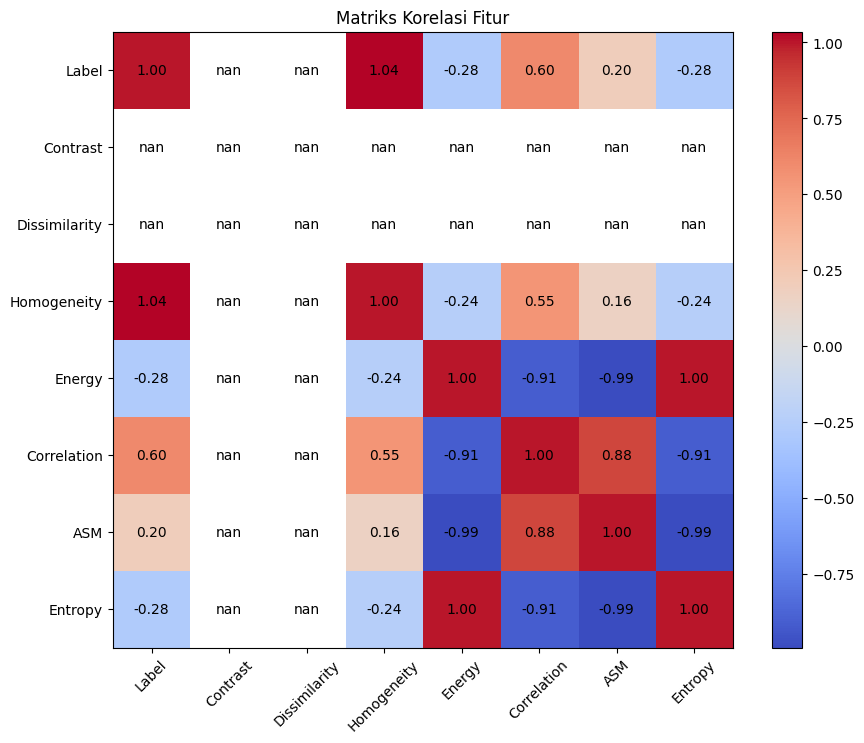

Selected Features: ['Homogeneity']
Selected Features: ['Homogeneity']
     Filename  Label  Contrast  Dissimilarity  Homogeneity    Energy  \
0  Filename_0      0       0.0            0.0          1.0  0.000117   
1  Filename_1      1       0.0            0.0          1.0  0.000118   
2  Filename_2      2       0.0            0.0          1.0  0.000117   
3  Filename_3      3       0.0            0.0          1.0  0.000118   
4  Filename_4      4       0.0            0.0          1.0  0.000116   

    Correlation       ASM   Entropy  
0  1.393670e+13  9.095642  0.000117  
1  1.379229e+13  9.087432  0.000118  
2  1.391445e+13  9.096183  0.000117  
3  1.378758e+13  9.086499  0.000118  
4  1.416450e+13  9.102133  0.000116  


In [12]:
def feature_selection_correlation(results):
    data = []
    columns = ['Filename', 'Label', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM', 'Entropy']
    for fname, label, features in results:
        row = [fname, label]
        row.extend(features.values())
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    
    df['Label'] = df['Label'].astype('category').cat.codes
    
    numeric_df = df.drop(columns=['Filename'])
    
    corr = numeric_df.corr()
    
    plt.figure(figsize=(10, 8))
    plt.title("Matriks Korelasi Fitur")
    plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.index)), corr.index)
    for i in range(len(corr.columns)):
        for j in range(len(corr.index)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    plt.show()
    
    selected_features = corr['Label'][(corr['Label'] > 0.99) | (corr['Label'] < -0.99)].index.tolist()
    selected_features.remove('Label')
    
    print("Selected Features:", selected_features)
    
    return df, selected_features

# Example usage:
# Assume you have a list of edge images called edge_images_prewitt_rotated
edge_images_prewitt_rotated = [
    # Replace with your actual edge images
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

# Calculate GLCM matrices
glcm_matrices = []
for edge_image in edge_images_prewitt_rotated:
    glcm_matrices.extend(calculate_glcm(edge_image))

# Calculate GLCM features
glcm_features = calculate_glcm_features(glcm_matrices)

# Prepare data for DataFrame
results = []
for i, features in enumerate(glcm_features):
    results.append((f'Filename_{i}', f'Label_{i}', features))

# Perform feature selection based on correlation
df_selected, selected_features = feature_selection_correlation(results)
print("Selected Features:", selected_features)
print(df_selected.head())

### Splitting Data

In [13]:
X = df_selected.drop(columns=['Label'])
y = df_selected['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (6, 8)
Testing data shape: (2, 8)


### Normalization

In [14]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

def min_max_normalization(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

X_train_normalized = X_train_numeric.apply(min_max_normalization, axis=0)

X_test_normalized = X_test_numeric.apply(min_max_normalization, axis=0)

print("Normalized Training data shape :", X_train_normalized.shape)
print("Normalized Testing data shape:", X_test_normalized.shape)

Normalized Training data shape : (6, 7)
Normalized Testing data shape: (2, 7)


## Modeling

In [15]:
X_train_numeric = X_train.drop(columns=['Filename'])
X_test_numeric = X_test.drop(columns=['Filename'])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_numeric, y_train)

y_pred_train = rf_classifier.predict(X_train_numeric)
y_pred_test = rf_classifier.predict(X_test_numeric)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

Training Accuracy: 1.0
Testing Accuracy: 0.0


## Evaluation

In [16]:
X_train_numeric = X_train.drop(columns=['Filename'])
X_test_numeric = X_test.drop(columns=['Filename'])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_numeric, y_train)

y_pred_train = rf_classifier.predict(X_train_numeric)
y_pred_test = rf_classifier.predict(X_test_numeric)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train, average='macro', zero_division='warn')
precision_test = precision_score(y_test, y_pred_test, average='macro', zero_division='warn')

recall_train = recall_score(y_train, y_pred_train, average='macro', zero_division='warn')
recall_test = recall_score(y_test, y_pred_test, average='macro', zero_division='warn')

f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division='warn')
f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division='warn')

print("Evaluation Metrics:")
print("-----------------------------------------------------")
print("| Metric      |   Training Set   |   Testing Set    |")
print("-----------------------------------------------------")
print("| Accuracy    |    {:.4f}        |    {:.4f}        |".format(accuracy_train, accuracy_test))
print("| Precision   |    {:.4f}        |    {:.4f}        |".format(precision_train, precision_test))
print("| Recall      |    {:.4f}        |    {:.4f}        |".format(recall_train, recall_test))
print("| F1-score    |    {:.4f}        |    {:.4f}        |".format(f1_train, f1_test))
print("-----------------------------------------------------")

print("Confusion Matrix:")
print("Training Set")
print(conf_matrix_train)
print("\nTesting Set")
print(conf_matrix_test)

Evaluation Metrics:
-----------------------------------------------------
| Metric      |   Training Set   |   Testing Set    |
-----------------------------------------------------
| Accuracy    |    1.0000        |    0.0000        |
| Precision   |    1.0000        |    0.0000        |
| Recall      |    1.0000        |    0.0000        |
| F1-score    |    1.0000        |    0.0000        |
-----------------------------------------------------
Confusion Matrix:
Training Set
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]

Testing Set
[[0 1 0]
 [0 0 0]
 [0 1 0]]
